In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.experiment_container import new_experiment

from qcodes.instrument_drivers.tektronix.DPO7200xx import TektronixDPO7000xx

In [2]:
tek = TektronixDPO7000xx("tek3", "TCPIP0::10.193.36.56::inst0::INSTR")

Connected to: TEKTRONIX DPO72004C (serial:C600651, firmware:CF:91.1CT FV:10.8.3 Build 3) in 0.55s


In [3]:
initialise_database()
experiment = new_experiment(name='DPO_72000_example', sample_name="no sample")

In [4]:
tek.channel[0].set_trace_time(2E-3)

In [5]:
tek.waveform.bytes_per_sample(2)

In [6]:
encodings = [
    "ASCIi",
    "FAStest",
    "RIBinary",
    "RPBinary",
    "FPBinary",
    "SRIbinary",
    "SRPbinary",
    "SFPbinary",
]

In [7]:
tek.data.encoding(encodings[2])

Starting experimental run with id: 110


([<matplotlib.axes._subplots.AxesSubplot at 0x295c1c47f28>,
 [None, None])

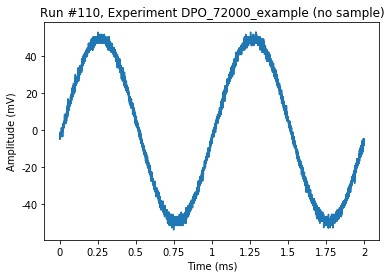

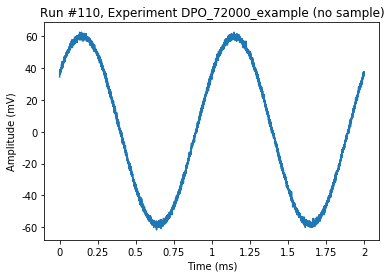

In [9]:
meas = Measurement(exp=experiment)
meas.register_parameter(tek.channel[0].trace)
meas.register_parameter(tek.channel[1].trace)

with meas.run() as datasaver:
    for i in [0, 1]:
        datasaver.add_result(
            (tek.channel[i].trace_axis, tek.channel[i].trace_axis()),
            (tek.channel[i].trace, tek.channel[i].trace())
        )

    dataid = datasaver.run_id

plot_by_id(dataid)

In [8]:
tek.measurement[0].source1("CH1")
tek.measurement[0].type("frequency")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

1000.60036022 Hz


In [9]:
tek.measurement[0].type("amplitude")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

0.09840000391006 V


In [10]:
tek.measurement[0].source1("CH2")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

0.11680000826716 V


In [11]:
tek.measurement[0].source1("CH1")
tek.measurement[0].source2("CH2")
tek.measurement[0].type("phase")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

-36.70127558588 °


In [13]:
tek.channel[0].scale()

0.0012

In [14]:
tek.channel[1].scale()

0.0008

In [15]:
tek.write("DATa:SOU MATH1")

In [16]:
tek.ask("DATa:SOU?")

'MATH1'

In [34]:
tek.waveform.bytes_per_sample()

4

In [24]:
tek.waveform.data_format()

'signed_integer'

In [39]:
#tek.waveform.data_format("ascii")

In [40]:
tek.data.encoding(encodings[0])

In [41]:
tek.data.encoding()

'ASCII'

In [30]:
tek.waveform.is_big_endian()

False

In [42]:
raw_data = tek.visa_handle.query_ascii_values(
    "CURVE?",
    container=np.array
)

In [43]:
import matplotlib.pyplot as plt 

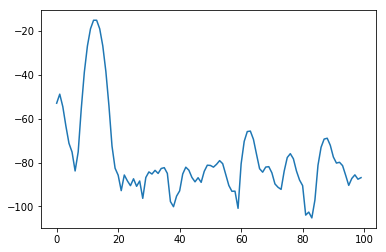

In [45]:
plt.plot(raw_data)

In [54]:
tek.data.encoding("RIBinary")

In [55]:
tek.data.encoding()

'FPBINARY'

In [56]:
tek.waveform.is_big_endian()

False

In [76]:
raw_data = tek.visa_handle.query_binary_values(
    "CURVE?",
    datatype="f",
    is_big_endian=True,
    container=np.array
)

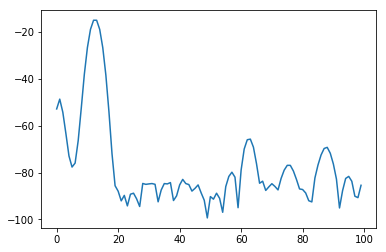

In [77]:
plt.plot(raw_data)